In [1]:
using TimerOutputs
using Gadfly
using StatsBase

In [23]:
include("../src/ssm1.jl")
include("../src/ssm2.jl")
include("../src/dfm.jl")

get_state_space_representation2 (generic function with 1 method)

In [24]:
n = 20

μ_true   = zeros(n)
λ_true   = ones(n)
ϕ_true   = 0.95
σ2v_true = 1.
ψ_true   = 0.90*ones(n)
σ2w_true = ones(n)

dfm_true  = MixedFreqDFM(μ_true, λ_true, ϕ_true, σ2v_true, ψ_true, σ2w_true)
ssm_true  = get_state_space_representation(dfm_true)
ssm2_true = get_state_space_representation2(dfm_true)

T1 = 300
ΔT = 24     # 2 years
T = T1 + ΔT

x_true, y_unobs = simulate(ssm_true, T)

f_true = [x_true[1:4,5]..., x_true[:,1]...] # indices -3:T

y = fill(NaN, T, n)
y[3:3:T1,1] = y_unobs[3:3:T1,1]
y[1:T1,2:n] = y_unobs[1:T1,2:n]

y

324×20 Array{Float64,2}:
 NaN         -4.13992    -0.0508852  …    1.23395    -4.89421   -0.852166
 NaN         -2.39559     1.04562         2.77969    -3.96072    1.90275 
  13.3726    -0.855473    1.1912          3.20713    -4.02225    3.4277  
 NaN         -0.333579    2.08789         3.77533    -4.49877    3.58451 
 NaN         -1.23624     0.44882         3.13844    -5.21517    2.21629 
  15.9985     0.475487    1.66682    …    3.88025    -5.36621    3.08413 
 NaN         -1.25094     2.15921         1.70639    -7.81509    3.19918 
 NaN         -1.29809     0.902053        0.900865   -7.05178    3.0206  
   5.08042   -2.58682    -0.109878       -0.958972   -9.83789    0.694934
 NaN         -1.38243     0.946165        0.113822   -8.23242    0.80303 
 NaN         -0.225958   -0.347936   …   -1.46285    -6.71203    0.466433
  -6.01104    0.682351    0.568268       -0.31663    -6.4013    -0.480532
 NaN          3.91577     2.24408         1.47352    -4.45225    1.59794 
   ⋮         

In [25]:
function autocov_q(ψ, Δt)
    return 19*ψ^(abs(Δt)) + 16*ψ^(abs(Δt-1)) + 16*ψ^(abs(Δt+1)) + 10*ψ^(abs(Δt-2))+10*ψ^(abs(Δt+2)) +
                             4*ψ^(abs(Δt-3)) +  4*ψ^(abs(Δt+3)) +    ψ^(abs(Δt-4))+   ψ^(abs(Δt+4))
end

autocov_q (generic function with 1 method)

In [26]:
const to = TimerOutput()

T, _ = size(y)

S = 1000

# parameters of priors
μλ_prior   = zeros(n)
σ2λ_prior  = 100.*ones(n)

# initialization
μ   = copy(μ_true)
λ   = copy(λ_true)
λ[1]= 0.5
ϕ   = 0.5 #copy(ϕ_true)
ψ   = copy(ψ_true)
ψ[1]= 0.5
σ2v = copy(σ2v_true)
σ2w = copy(σ2w_true)

# for storage
f_all     = zeros(S, T+4)
μ_all     = zeros(S, n)
λ_all     = zeros(S, n)
ϕ_all     = zeros(S, 1)
ψ_all     = zeros(S, n)
σ2v_all   = zeros(S, 1)
σ2w_all   = zeros(S, n)
ypred_all = zeros(S, ΔT+1, n)


for s=1:S
    
    @timeit to "transform y" begin
       
        y_transf = zeros(T,n)
        y_transf[:,1]     = y[:,1]
        y_transf[1,2:n]   = y[1,2:n]
        y_transf[2:T,2:n] = y[2:T,2:n] - ψ[2:n]'.*y[1:T-1,2:n]
        
    end
    
    @timeit to "simulation smoother" begin
        
        dfm   = MixedFreqDFM(μ, λ, ϕ, σ2v, ψ, σ2w)
        ssm2  = get_state_space_representation2(dfm)
        
        x = simulation_smoothing_carter_kohn(y_transf, ssm2)
        
        # alternative: Durbin and Koopman (2002) algorithm
        #=
                
        ssm  = get_state_space_representation(dfm)
        x_sim, y_sim_unobs = simulate(ssm, T)
        #y_sim = y_sim_unobs[.~isnan.(y)]
        y_sim = fill(NaN, T, n)
        y_sim[3:3:T1,1] = y_sim_unobs[3:3:T1,1]
        y_sim[1:T1,2:n] = y_sim_unobs[1:T1,2:n]
        y_transf_sim = zeros(T,n)
        y_transf_sim[:,1]     = y_sim[:,1]
        y_transf_sim[1,2:n]   = y_sim[1,2:n]
        y_transf_sim[2:T,2:n] = y_sim[2:T,2:n] - ψ_true[2:n]'.*y_sim[1:T-1,2:n]
        
        xs     = fast_state_smoothing(y_transf    , ssm2)
        xs_sim = fast_state_smoothing(y_transf_sim, ssm2)
        
        x = x_sim[:,1:10] - xs_sim + xs
        =#
        
    end
    
    @timeit to "sample ϕ (σ2v = 1)" begin
        # no prior and not entirely correct!
        f   = [x[1:4,5]..., x[:,1]...]
        σ2ϕ = σ2v/(f[1:T-1]'*f[1:T-1])
        μϕ = (f[1:T-1]'*f[2:T])/(f[1:T-1]'*f[1:T-1])
        ϕ = rand(TruncatedNormal(μϕ, sqrt(σ2ϕ), -1, 1))
        
    end
    
    @timeit to "sample μ, λ, ψ, σ2w" begin
        
        λ = zeros(n)
        λ[2:n] = λ_true[2:n] # TODO: delete
        
        @timeit to "sample λ1" begin
            Φ = σ2w[1]/(1-ψ[1]^2)*[autocov_q(ψ[1], i-j) for i=3:3:T1, j=3:3:T1]
            fq = 1/3*x[3:3:T1,1] + 2/3*x[3:3:T1,2] + x[3:3:T1,3] + 2/3*x[3:3:T1,4] + 1/3*x[3:3:T1,5]
            b  = y[3:3:T1,1] - 3*μ[1]
            Jλ = fq'*(Φ\fq) + 1/σ2λ_prior[1]
            hλ = fq'*(Φ\b) + μλ_prior[1]/σ2λ_prior[1]
            λ[1] = rand(Normal(hλ/Jλ,sqrt(1/Jλ)))
        end
        
        @timeit to "sample λi for i=2:n" begin
            
        end
        
        ψ = zeros(n)
        ψ[2:n] = ψ_true[2:n] # TODO: delete
    
        @timeit to "sample ψ1" begin
            # no prior and not entirely correct!
            u1  = [x[1:4,10]..., x[:,6]...]
            σ2ψ = σ2v/(u1[1:T-1]'*u1[1:T-1])
            μψ  = (u1[1:T-1]'*u1[2:T])/(u1[1:T-1]'*u1[1:T-1])
            ψ[1]   = rand(TruncatedNormal(μψ, sqrt(σ2ψ), -1, 1))
        end
        
        @timeit to "sample ψi for i=2:n" begin
            # ui = y[1:T1,i] - λ[i]*x[1:T1,1]
            
        end
        
    end
    
    @timeit to "sample y_pred" begin
        
        ypred = zeros(ΔT+1,n)
        # ypred = ones(ΔT+1,1)*μ'+x[T1:T,:]*B' # TODO: this does not hold for the second state space representation!!!
        
    end
    
    @timeit to "save" begin
        
        f_all[s,:]       = [x[1:4,5]..., x[:,1]...]
        μ_all[s,:]       = μ
        λ_all[s,:]       = λ
        ϕ_all[s,:]       = ϕ
        ψ_all[s,:]       = ψ
        σ2v_all[s,:]     = σ2v
        σ2w_all[s,:]     = σ2w
        ypred_all[s,:,:] = ypred
        
    end
    
    
end


In [27]:
show(to)

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            57.6s / 97.9%           21.0GiB / 100%     

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 simulation smoother    1.00k    42.4s  75.2%  42.4ms   19.0GiB  90.6%  19.4MiB
 sample μ, λ, ψ, σ2w    1.00k    13.6s  24.1%  13.6ms   1.69GiB  8.07%  1.73MiB
   sample λ1            1.00k    13.5s  24.0%  13.5ms   1.66GiB  7.94%  1.70MiB
   sample ψ1            1.00k   25.1ms  0.04%  25.1μs   26.5MiB  0.12%  27.2KiB
   sample λi for i=2:n  1.00k    262μs  0.00%   262ns         -  0.00%        -
   sample ψi for i=2:n  1.00k   98.8μs  0.00%  98.8ns         -  0.00%        -
 transform y            1.00k    332ms 

In [28]:
cutoff = 500

500

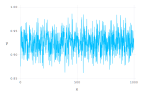

In [29]:
plot(x=1:S, y=ϕ_all, Geom.line)

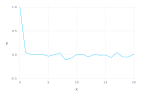

In [30]:
plot(x=0:20, y=autocor(ϕ_all[cutoff:end], 0:20), Geom.line)

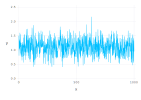

In [31]:
plot(x=1:S, y=λ_all[:,1], Geom.line)

In [32]:
mean(λ_all[cutoff:end,1])

1.100060021410739

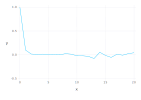

In [33]:
plot(x=0:20, y=autocor(λ_all[cutoff:end,1], 0:20), Geom.line)

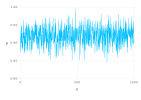

In [34]:
plot(x=1:S, y=ψ_all[:,1], Geom.line)

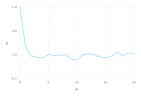

In [35]:
plot(x=0:20, y=autocor(ψ_all[cutoff:end,1], 0:20), Geom.line)

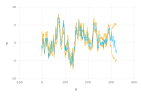

In [36]:
f_low  = [quantile(f_all[cutoff:end,t], 0.025) for t=1:T+4]
f_high = [quantile(f_all[cutoff:end,t], 0.975) for t=1:T+4];

plot(
    layer(x=-3:T, y=f_true, Geom.line),
    layer(x=-3:T, y=f_high, Geom.line, Theme(default_color="orange")),
    layer(x=-3:T, y=f_low, Geom.line, Theme(default_color="orange")),
)

### Possible prior for $\phi$: Beta-distribution with $\alpha=5$ and $\beta=1.05$

In [37]:
using Distributions

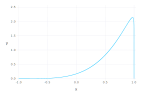

In [38]:
d = Beta(5,1.05)
plot(x=-1:0.0001:1, y=1/2*pdf.(d, 0:0.00005:1), Geom.line)

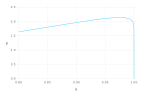

In [39]:
plot(x=0.8:0.0001:1, y=1/2*pdf.(d, 0.9:0.00005:1), Geom.line) # relatively flat in the interval that seems likely

In [40]:
2*(5-1)/(5+1.05-2)-1 # mode

0.9753086419753088